In [2]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import scipy as sp
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn import TransformerEncoder, TransformerEncoderLayer
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF
import random
from torch.utils.data.dataloader import default_collate
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
import math

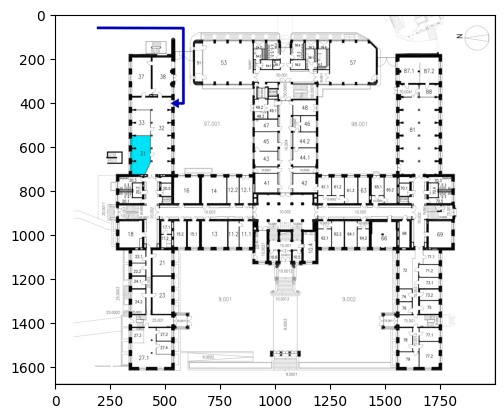

In [3]:
background = cv2.imread("data/cab_floor_0.png")
plt.imshow(background)

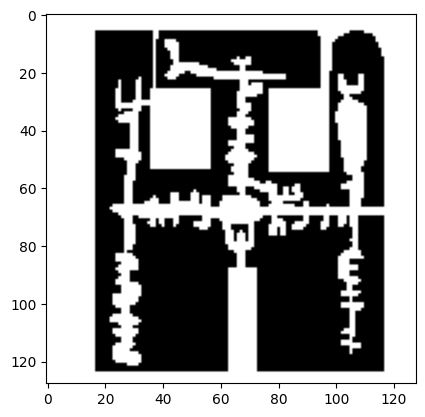

In [136]:
walk_mask = cv2.imread("data/cab_floor_0_walk.png")
walk_mask = np.logical_and(walk_mask[:,:,0] > 200, walk_mask[:,:,1] < 100)
walk_mask = cv2.resize(walk_mask.astype(np.float32), (128,128)).astype(bool)
(h,w) = walk_mask.shape

plt.imshow(walk_mask, cmap='gray')

In [5]:
!pip install rustworkx
import rustworkx

In [137]:
graph = rustworkx.PyGraph()

nodes = [[]]
for i in range(walk_mask.shape[0]):
    nodes.append([])
    for j in range(walk_mask.shape[1]):
        if walk_mask[i,j]:
            nodes[i].append(graph.add_node((j,i)))
        else:
            nodes[i].append(None)

for i in range(walk_mask.shape[0]):
    for j in range(walk_mask.shape[1]):
        if not walk_mask[i][j]:
            continue
        if i>0 and walk_mask[i-1][j]:
            graph.add_edge(nodes[i-1][j], nodes[i][j], 1)
        if i<walk_mask.shape[0]-1 and walk_mask[i+1][j]:
            graph.add_edge(nodes[i+1][j], nodes[i][j], 1)
        if j>0 and walk_mask[i][j-1]:
            graph.add_edge(nodes[i][j-1], nodes[i][j], 1)
        if j<walk_mask.shape[1]-1 and walk_mask[i][j+1]:
            graph.add_edge(nodes[i][j+1], nodes[i][j], 1)

nodes = np.array(graph.nodes())
print(nodes.shape)

(8481, 2)


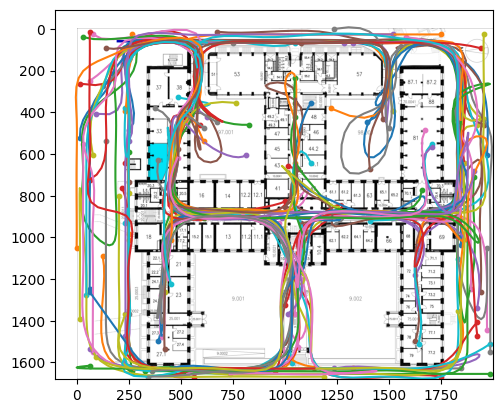

In [140]:
def gen_shortest_path(min_len, n_waypoints):
    assert n_waypoints >= 2

    while True:
        waypoints = np.random.choice(graph.node_indices(), size=n_waypoints)

        paths = []
        retry = False
        for i in range(n_waypoints-1):
            start,end = waypoints[i:i+2]
            path = rustworkx.dijkstra_shortest_paths(graph,start,end)
            if not end in path:
                retry = True
                break
            path = np.array(rustworkx.dijkstra_shortest_paths(graph,start,end)[end], dtype=int)
            paths.append(path[:-1])

        if retry:
            continue
        paths = np.concatenate(paths)

        if paths.shape[0] > min_len:
            return nodes[paths[:min_len]] / [w,h]

def smooth_path(path, keypoint_stride=16, interpolating_stride=4):
    n = path.shape[0]
    waypoints = path[::keypoint_stride, :]

    spline = sp.interpolate.make_interp_spline(x=np.linspace(0,n-1,len(waypoints)), y=waypoints)

    smooth = spline(np.linspace(0,n-1, n//interpolating_stride))
    return smooth

def plot_paths(img, path, endpoint_s=10):
    plt.imshow(img, cmap='gray')

    scaley, scalex = img.shape[0:2]

    if not isinstance(path,list):
        path = [path]

    for p in path:
        start,end = p[0,:], p[-1,:]
        plt.plot(p[:,0]*scalex, p[:,1]*scaley)
        plt.scatter([scalex*start[0],scalex*end[0]], [scaley*start[1],scaley*end[1]], s=endpoint_s)


def gen_path(min_len, n_waypoints):
    path = gen_shortest_path(min_len, n_waypoints)
    path = smooth_path(path)
    return path


k = 100
min_len = 200
n_waypoints = 4
paths = []
for i in range(k):
    paths.append(gen_path(min_len, n_waypoints=n_waypoints))

plot_paths(background,paths)

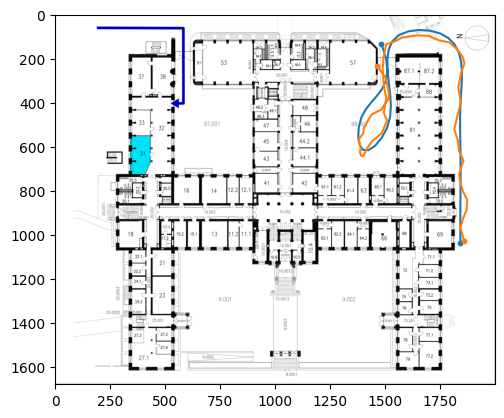

In [141]:
def add_noise_path(path, noise):
    n = path.shape[0]

    o = np.random.uniform(low=-noise, high=noise, size=(n,2))
    new_path = path + np.cumsum(o, axis=0)
    return new_path

noise = 10e-3

path = paths[0]
noisy_path = add_noise_path(path, noise)

plot_paths(background, [path, noisy_path])

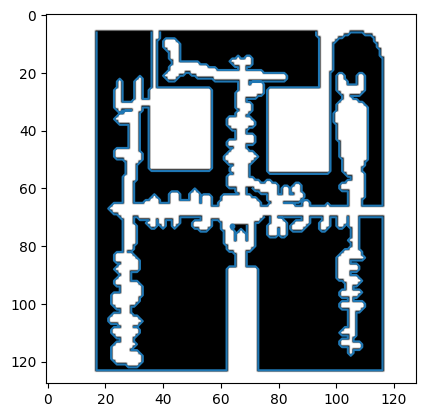

In [164]:
contours, _ = cv2.findContours(255 - 255*walk_mask.astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours = [np.append(c[:,0,:], [[np.nan,np.nan]], axis=0).astype(np.float32) / [w,h] for c in contours]
contours = np.concatenate(contours)
plot_paths(walk_mask, contours)
plt.imshow(walk_mask, cmap='gray')

In [161]:
np.append([[10,20], [20,30], [40,50]], [[1,2]], axis=0)

array([[10, 20],
       [20, 30],
       [40, 50],
       [ 1,  2]])

In [179]:
class PathDataset(Dataset):
    def __init__(self, min_len, min_incorrect_dist, noise, n_waypoints, n_paths, n_correct_per_path, n_incorrect_per_path, resolution=(128,128)):
        paths = []
        for i in range(n_paths):
            path = gen_path(min_len, n_waypoints=n_waypoints)
            paths.append(path)

        noisy_paths = []
        for path in paths:
            noisy_paths.append([add_noise_path(path, noise=noise) for i in range(n_correct_per_path)])

        self.paths = []
        self.labels = []
        self.resolution = resolution

        for i in range(n_paths):
            end = paths[i][-1]

            for path in noisy_paths[i]:
                self.paths.append((path + (end - path[-1,:])).astype(np.float32))
                self.labels.append((1.0, paths[i].astype(np.float32)))
            #continue

            exl_self = noisy_paths[:i] + noisy_paths[i+1:]

            def choose(p):
                return p[random.randint(0,len(p)-1)]

            for j in range(n_incorrect_per_path):
                while True:
                    sel_paths = choose(exl_self)
                    p = choose(choose(exl_self))

                    if np.linalg.norm(p[-1] - end) < min_incorrect_dist:
                        continue

                    p = p + (end - p[-1,:]) # make path end at location
                    self.paths.append(p.astype(np.float32))
                    self.labels.append((0.0, paths[i].astype(np.float32)))
                    break

        #max_len = max(map(len, self.paths))
        #self.paths = [np.concatenate([p, np.zeros((max_len-p.shape[0],2))]).astype(np.float32) for p in paths]
        #print(max_len)
        print(self.paths[0].shape)


    def __len__(self):
        return len(self.paths)

    def rasterize(self, path):
        (scaley,scalex) = self.resolution
        img1 = np.zeros((scaley, scalex, 3), dtype=np.float32)
        img2 = np.zeros((scaley, scalex, 3), dtype=np.float32)

        cv2.polylines(img1, (path * [scalex,scaley]).reshape((1,-1,1,2)).astype(np.int32), color=[1.0,0.0,0.0], thickness=scalex//30, isClosed=False)
        #cv2.polylines(img2, (contours * [scalex,scaley]).reshape((1,-1,1,2)).astype(np.int32), color=[0.0,1.0,0.0], thickness=scaley//30, isClosed=False)
        img2[:,:,1] = walk_mask
        
        return img1 + img2
    
    def __getitem__(self, idx):
        path = self.paths[idx]
        (label, ref_path) = self.labels[idx]
        
        return self.rasterize(path), (label, self.rasterize(ref_path))

(25, 2)
(50, 2)
1.0


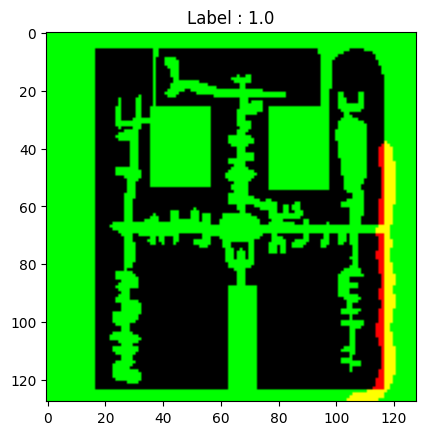

In [180]:
dataset = PathDataset(
    min_len = 100,
    n_waypoints=4,
    noise=1e-2,
    min_incorrect_dist=0.3,
    n_paths=10,
    n_correct_per_path=10,
    n_incorrect_per_path=10
)

print(gen_path(min_len=200, n_waypoints=4).shape)
img, (label,p2) = dataset[0]
print(img.max())
plt.title("Label : " + str(label))
plt.imshow(img, cmap='gray')
#plot_paths(background, [path])

In [220]:
class PathClassifier(nn.Module):
    def __init__(self):
        super(PathClassifier, self).__init__()
        
        self.align = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=3, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(8, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 64 x 64
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.LeakyReLU()
        )

        self.classify = nn.Sequential(
            nn.MaxPool2d(kernel_size=2, stride=2), # 32 x 32
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 16 x 16,
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 8 x 8,
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 4 x 4,
            nn.Flatten(), # 4x4x128 = 
            nn.Linear(2048, 256),
            nn.LeakyReLU(),
            nn.Linear(256, 64),
            nn.LeakyReLU(),
            nn.Linear(64, 1),
        )
        
    def encode_map(self, map_contour):
        #y = self.map_encoder(map_contour.unsqueeze(0)).squeeze(0)
        return None

    def forward(self,x, map_embed):
        x = 255*x
        align = self.align(x)
        pred = self.classify(align)
        return torch.sigmoid(pred.squeeze(1)), align

torch.manual_seed(42)
model = PathClassifier()
print(np.sum(path))

#model(torch.tensor([path],dtype=torch.float32), model.encode_map(torch.tensor(contours, dtype=torch.float32)))
model(torch.ones((2,3,128,128)), None)

9437.0


(tensor([0.4829, 0.4829], grad_fn=<SigmoidBackward0>),
 tensor([[[[-6.6642e-03, -4.7051e-03, -4.0786e-03,  ..., -4.3399e-03,
            -2.2323e-03, -9.8571e-04],
           [-2.7590e-04,  9.0677e-01,  1.1875e+00,  ...,  1.3128e+00,
             1.3473e+00,  4.4465e-01],
           [ 6.2283e-01,  1.1650e+00,  1.4002e+00,  ...,  1.5802e+00,
             1.4902e+00,  1.6486e-01],
           ...,
           [ 2.2401e-01,  5.5300e-01,  7.7037e-01,  ...,  9.2170e-01,
             1.1298e+00,  7.4442e-02],
           [ 1.2106e-01,  2.5080e-01,  5.4043e-01,  ...,  5.8110e-01,
             6.4600e-01,  1.3960e-02],
           [ 2.5835e-01,  4.6114e-01,  6.0841e-01,  ...,  6.9405e-01,
             1.0787e+00,  8.6319e-02]],
 
          [[-8.8726e-03, -9.7718e-03, -9.3745e-03,  ..., -1.1220e-02,
            -1.3096e-02, -6.8935e-03],
           [-5.1753e-03, -4.1159e-04,  7.0593e-02,  ..., -2.1901e-03,
            -6.5971e-03,  8.2099e-02],
           [-3.6402e-03,  1.8070e-02,  1.6040e-01,  ..

In [32]:
model.model[-9].weight

Parameter containing:
tensor([[[[ 8.1840e-03, -1.4819e-03, -7.2251e-03],
          [-3.2787e-03,  7.1883e-04, -3.9707e-04],
          [-8.2236e-03,  9.1247e-03, -8.4842e-03]],

         [[ 1.1843e-04, -8.5050e-03, -8.7698e-03],
          [ 1.6422e-03, -7.0945e-03, -6.8707e-03],
          [ 7.2230e-03, -8.3728e-03, -1.5777e-03]],

         [[-6.0249e-03, -6.9531e-03, -8.0359e-03],
          [ 6.1804e-03, -1.1748e-03, -8.0409e-03],
          [ 2.4460e-03,  1.0123e-04,  7.2202e-03]],

         ...,

         [[-9.6672e-03,  7.2325e-03, -7.8536e-03],
          [ 2.0386e-03, -3.1420e-03,  5.9681e-03],
          [ 4.9443e-03, -8.4217e-03,  4.2058e-03]],

         [[-1.0186e-02, -3.5169e-03, -5.2590e-03],
          [-9.1678e-03,  2.4020e-05, -9.9844e-03],
          [-5.7859e-03, -7.6283e-03,  6.1943e-03]],

         [[-6.8584e-03,  2.0051e-03,  5.7846e-03],
          [ 8.0505e-03, -4.0371e-03,  1.0255e-02],
          [ 5.9316e-03,  2.9003e-03, -8.5181e-04]]],


        [[[ 2.5842e-03,  7.9370

In [184]:
device = torch.device("mps:0")

In [185]:
dataset_training = PathDataset(
    min_len = 200,
    n_waypoints=4,
    noise=1e-2,
    min_incorrect_dist=0.3,
    n_paths=2000,
    n_correct_per_path=10,
    n_incorrect_per_path=10
)
dataset_test = PathDataset(
    min_len = 200,
    n_waypoints=4,
    noise=1e-2,
    min_incorrect_dist=0.3,
    n_paths=2000,
    n_correct_per_path=10,
    n_incorrect_per_path=10,
)

(50, 2)
(50, 2)


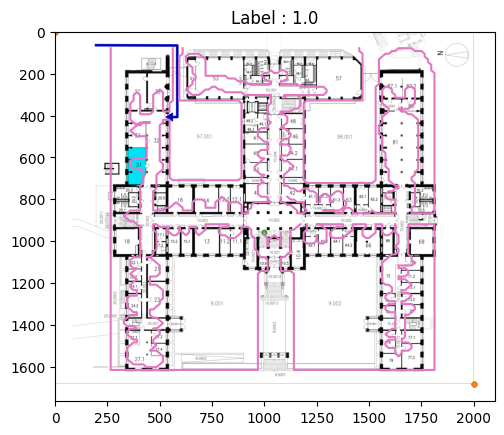

In [186]:
path, (label,ref_path) = dataset_training[3]

plt.title("Label : " + str(label))
plot_paths(background, [path, ref_path, contours])

In [187]:
def collate(x):
    inps = []
    labels = []
    refs = []

    for inp, (label,ref) in x:
        inps.append(TF.to_tensor(inp))
        labels.append(label)
        refs.append(TF.to_tensor(ref))

    inp = np.stack(inps)
    labels = np.array(labels,dtype=np.float32)
    ref = np.stack(refs)

    return (torch.tensor(inp).to(device), (torch.tensor(labels).to(device), torch.tensor(ref).to(device)))

batch_size = 4
train_loader = torch.utils.data.DataLoader(dataset_training, batch_size=batch_size, shuffle=True, collate_fn=collate)
test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size, shuffle=True, collate_fn=collate)

tensor([0., 1., 0., 0.], device='mps:0')


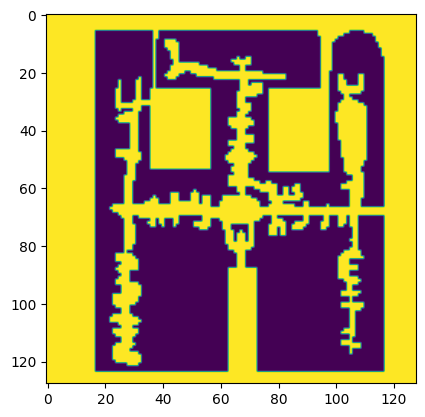

In [192]:
itr = train_loader.__iter__()
x1,(label1,ref) = next(itr)
x2,(label2,ref) = next(itr)
x3,(label3,ref) = next(itr)

#print(x[1]-x[0].sum())
#print(x.shape, label, ref.shape)

print(label3)

plt.imshow(x3[0,1,:,:].cpu())

In [20]:
contours_device = torch.tensor(contours, dtype=torch.float32).to(device)

In [193]:
def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0.
    running_acc = 0
    last_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(train_loader):
        inputs, labels = data
        batch_size = inputs.shape[0]

        optimizer.zero_grad()

        outputs = model(inputs, None)

        loss = loss_fn(outputs, labels)
        #print("First loss ", loss)
        loss.backward()
        #print("LABEL ", labels[0])
        #print("PRED ", outputs[0])

        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        running_acc += ((outputs[0]>0.5)==(labels[0]>0.5)).sum().item()
        if i % 50 == 49:
            last_loss = running_loss / 50 # loss per batch
            last_acc = running_acc / 50 / batch_size
            print('  batch {} loss: {}, acc: {}'.format(i + 1, last_loss, last_acc))
            tb_x = epoch_index * len(train_loader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            tb_writer.add_scalar('Acc/train', last_acc, tb_x)
            running_loss = 0.
            running_acc = 0.

    return last_loss, last_acc

In [194]:
bce_loss = torch.nn.BCELoss()
huber_loss = torch.nn.HuberLoss(reduction='sum')

def loss_fn(pred, labels):
    label_pred, path_pred = pred
    label_ref, path_ref = labels
    eps = 1e-3

    return bce_loss((1-2*eps)*label_pred+eps,(1-2*eps)*label_ref+eps)

In [195]:
print(device)

mps:0


In [ ]:
# Initializing in a separate cell so we can easily add more epochs to the same run

model = PathClassifier().to(device)

optimizer = torch.optim.SGD(params=model.parameters(), lr=5e-3)

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('data/runs/path_classifier')
epoch_number = 0

EPOCHS = 10

best_vloss = 1_000_000.

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss, avg_acc  = train_one_epoch(epoch_number, writer)

    running_vloss = 0.0
    running_vacc = 0
    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    model.eval()

    # Disable gradient computation and reduce memory consumption.
    with torch.no_grad():
        for i, vdata in enumerate(test_loader):
            vinputs, vlabels = vdata
            voutputs = model(vinputs, None)
            vloss = loss_fn(voutputs, vlabels)
            running_vloss += vloss
            running_vacc += ((voutputs[0]>0.5)==(vlabels[0]>0.5)).sum().item()

    test_batch_size = next(test_loader.__iter__())[0].shape[0]

    avg_vloss = running_vloss / (i + 1)
    avg_vacc = running_vacc / (i + 1) / test_batch_size
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training acc' : avg_acc, 'Validation acc' : avg_vacc},
                    epoch_number + 1)
    writer.flush()

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        torch.save(model.state_dict(), model_path)

    epoch_number += 1



EPOCH 1:
  batch 50 loss: 0.6922070765495301, acc: 0.545
  batch 100 loss: 0.6937241351604462, acc: 0.485
  batch 150 loss: 0.6934020721912384, acc: 0.49
  batch 200 loss: 0.6931969034671783, acc: 0.515
  batch 250 loss: 0.6927466714382171, acc: 0.52
  batch 300 loss: 0.6927624344825745, acc: 0.515
  batch 350 loss: 0.6925024962425232, acc: 0.53
  batch 400 loss: 0.6921618521213532, acc: 0.585
  batch 450 loss: 0.6920305681228638, acc: 0.515
  batch 500 loss: 0.6918169224262237, acc: 0.54
  batch 550 loss: 0.6912395453453064, acc: 0.56
  batch 600 loss: 0.6900768578052521, acc: 0.61
  batch 650 loss: 0.6900819194316864, acc: 0.52
  batch 700 loss: 0.6891047143936158, acc: 0.635
  batch 750 loss: 0.6839276778697968, acc: 0.575
  batch 800 loss: 0.6774787998199463, acc: 0.515
  batch 850 loss: 0.6600773286819458, acc: 0.54
  batch 900 loss: 0.650436007976532, acc: 0.535
  batch 950 loss: 0.6226009345054626, acc: 0.605
  batch 1000 loss: 0.5939029055833817, acc: 0.67
  batch 1050 loss: 0.

In [197]:
dataset = PathDataset(
    min_len = 200,
    n_waypoints=4,
    noise=3e-2,
    min_incorrect_dist=0.3,
    n_paths=200,
    n_correct_per_path=1,
    n_incorrect_per_path=1
)


#pred_path = pred_path.cpu().detach().numpy()


(50, 2)


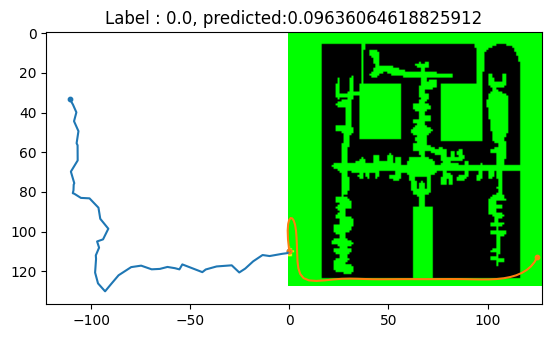

In [218]:
it = 13
img, label = dataset[it]

pred_label,pred_path = model(TF.to_tensor(img).to(device).unsqueeze(0), None)
pred_label = pred_label.item()

plt.title("Label : " + str(label[0]) + ", predicted:" + str(pred_label))
plot_paths(img, [dataset.paths[it], dataset.labels[it][1]])
#plt.imshow(img)